This is a fairly complex assemblage of python code that produces animations of tree diffusion over a landscape using matplotlib. A large part of it is the lightweight tree parser "Freki" that has evolved from a [linked list script](http://stackoverflow.com/questions/280243/python-linked-list/280286#280286) on stackoverflow. An even bigger part is tinkering with matplotlib to produce pretty figures, which can be removed. To begin there are several things that you will need to provide to use this script (or modify the code to proceed):
- *Maximum clade credibility (MCC) tree with phylogeography annotations*. This one is a must, since we're animating a tree and the tree should say where each lineage is inferred to be.
- *A map*. We went for GeoJSON files with administrative divisions of West African countries. These were additionally edited so that each division could be related to a location in the MCC tree. If you have another file format that contains coordinates that can define location polygons and that can be mapped to locations defined in the tree you can use that instead.
- *Location points* (optional). These are the population centroides and also define the points between which lineages travel. These points also grow and shrink depending on how many lineages are co-circulating within a location. You could use the mean of X and Y coordinates of a location to define these points instead, which might [land you in water](https://en.wikipedia.org/wiki/Coastline_paradox). Alternatively you could find [convex hulls](https://en.wikipedia.org/wiki/Convex_hull) of each location and use the mean of their X and Y coordinates to define the points of travel.
- *Case numbers* (optional). This is used to colour locations based on how many cases exist at the time point. With some modification of the code could be used to show anything.
- *Standardised names* (optional). This maps the "standardised" names of each location back to the original name with diacritic marks. Just trying to be considerate towards another language.
- *Plotting assist* (optional). This encodes information (vertical and horizontal text alignment) to position location names so they don't obscure each other. Ideally should be done automatically using something like [Coulomb's law](https://en.wikipedia.org/wiki/Coulomb%27s_law).

The animation works by going through each epi week in small slices, interpolating case numbers between each epi week report. This is animated in each frame as a change in colour intensity. At each time slice the tree is also cut up and lineages that exist at that time point are animated if they are travelling from one location to another, otherwise they just count towards the circle size of each population centroid. The lineages that are travelling are animated using [Bezier curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve) with a single control point placed at a given distance perpendicular to the line connecting points A and B between which lineages are travelling. Each Bezier line is defined by a number of segments which decrease in size towards the origin of the travelling lineage, giving them the comet-like appearance in the animation. 

There are two advantages to using Bezier curves:
- Two lineages travelling from A to B and from B to A will not obscure each other. One will arc up, the other one will arc down.
- The control point for the Bezier curve can be positioned at any distance from the direct line between points A and B. That means you can set the control point to be at a distance inversely proportional to the distance between points A and B, such that a lineage traveling far travels in nearly straight lines, but arc heavily when traveling between close points, ensuring locations close to each other exchanging viruses are not missed by the viewer. 

Also enjoy the music. If you like it - please consider buying the album (the dude's really friendly and appreciates the support).

In [1]:
from IPython.display import HTML
license='<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Gytis Dudas</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.'
HTML(license)

In [2]:
fr='<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The movie from my presentation at <a href="https://twitter.com/hashtag/VGE16?src=hash">#VGE16</a> can be seen here: <a href="https://t.co/SjSwOYAWVM">https://t.co/SjSwOYAWVM</a></p>&mdash; evoGytis (@evogytis) <a href="https://twitter.com/evogytis/status/741215926482132992">June 10, 2016</a></blockquote><script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>'
HTML(fr)

### Import relevant information
Viridis colourmap, population centroid locations, administrative division maps, case numbers, additional files for pretty plotting.

In [3]:
import matplotlib as mpl ## matplotlib should not be set to inline mode to accelerate animation rendering and save memory
mpl.use('Agg') ## recommended backend for animations
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.special import binom

from ebov_data import * ## load library

if locations: ## if data loaded previously - do nothing
    pass
else: ## call status, set countries, colour maps and load data
    status()
    setFocusCountries(focus=['SLE','LBR','GIN'])
    setColourMaps()
    loadData()

typeface='Helvetica Neue' ## set default matplotlib font and font size
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

countryCaseCounts={} ## Output case numbers for each country separately

maxByCountry={}
for country in required_countries:
    countryCaseCounts[country]=np.vstack([[cases_byLocation[x][y] for y in dates] for x in cases_byLocation.keys() if country==location_to_country[x]]) ## stack case counts across locations
    countryCaseCounts[country]=np.sum(countryCaseCounts[country],axis=0)

    maxByCountry[country]=max([sum(cases_byLocation[x].values()) for x in cases_byLocation.keys() if location_to_country[x]==country]) ## find the location with the highest cumulative case numbers within each country
    if maxByCountry[country]==0.0:
        maxByCountry[country]=0.01

totalCaseCounts={loc:sum(cases_byLocation[loc].values()) for loc in cases_byLocation.keys()}
print '\n\nhighest case count in country:\n%s'%('\n'.join(['%s: %s'%(x,maxByCountry[x]) for x in maxByCountry.keys()]))

print '\ncase report dates: %s'%('\t'.join(dates))
print '\nnumber of districts in case report: %s'%(len([x for x in cases_byLocation.keys() if sum(cases_byLocation[x].values())>=1.0]))
print '\ndate of most recent report: %s'%(dates[-1])
frame='<iframe style="border: 0; width: 400px; height: 345px;" src="https://bandcamp.com/EmbeddedPlayer/album=2074815275/size=large/bgcol=ffffff/linkcol=63b2cc/artwork=small/track=42188979/transparent=true/" seamless><a href="http://obsrr.bandcamp.com/album/nustebusiam-neb-ti">NUSTEBUSIAM NEBUTI by OBSRR</a></iframe>'

print 'Done!'
HTML(frame)

Operating system:       Darwin (15.6.0)
Python version:         2.7.11
Numpy version:          1.11.1
Pandas version:         0.18.1
matplotlib version:      1.5.1
scipy version:          0.17.0

This notebook was last run on:
Friday	2016-Sep-16	11:57	PDT


highest case count in country:
SLE: 3219
LBR: 2925
GIN: 784

case report dates: 2013-12-30	2014-01-06	2014-01-13	2014-01-20	2014-01-27	2014-02-03	2014-02-10	2014-02-17	2014-02-24	2014-03-03	2014-03-10	2014-03-17	2014-03-24	2014-03-31	2014-04-07	2014-04-14	2014-04-21	2014-04-28	2014-05-05	2014-05-12	2014-05-19	2014-05-26	2014-06-02	2014-06-09	2014-06-16	2014-06-23	2014-06-30	2014-07-07	2014-07-14	2014-07-21	2014-07-28	2014-08-04	2014-08-11	2014-08-18	2014-08-25	2014-09-01	2014-09-08	2014-09-15	2014-09-22	2014-09-29	2014-10-06	2014-10-13	2014-10-20	2014-10-27	2014-11-03	2014-11-10	2014-11-17	2014-11-24	2014-12-01	2014-12-08	2014-12-15	2014-12-22	2014-12-29	2015-01-05	2015-01-12	2015-01-19	2015-01-26	2015-02-02	2015-02-09	2015-02-16	20

### First test - plotting cumulative case numbers per country.

In [ ]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w') ## start figure

for i,loc in enumerate(locations): ## iterate over locations
    country=location_to_country[loc]
    countryColour=colours[country] ## fetch colour map for country
    
    if country in required_countries:
        if totalCaseCounts.has_key(loc):
            caseFrac=totalCaseCounts[loc]/float(maxByCountry[country]) ## get the location's case numbers as fraction of the highest cumulative case numbers in the country
        else:
            caseFrac=0.0

        c=countryColour(caseFrac) ## get colour

        for part in location_points[loc]: ## plot location borders and polygons
            xs=column(part,0)
            ys=column(part,1)
            ax.plot(xs,ys,color='grey',lw=1,zorder=0) ## mpl won't draw polygons unless there's something plotted

        ax.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='grey',lw=1,zorder=1)) ## add polygon

        lon,lat=popCentres[loc] ## plot population centres
        ax.scatter(lon,lat,80,facecolor=c,edgecolor=desaturate(countryColour(1-caseFrac),1.0),lw=2,zorder=2)

        vas=['bottom','top'] ## define available text alignments and corrections for text positions
        has=['left','right']
        corrections=[0.02,-0.02]

        h=1 ## set default text alignment (right, top)
        v=1
        if textCorrection.has_key(loc): ## check if custom text positions are available
            h,v=textCorrection[loc]
        
        ax.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=20,va=vas[v],ha=has[h],
                alpha=0.8,path_effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                                        path_effects.Stroke(linewidth=0.5, foreground='black')]) ## plot district names at population centres, with corrections so as not to obscure it

ycoord=np.mean([4.3,12.7]) ## this plots a distance bar to indicate distances in the map (set at 100km)
legend_y=12.0
legend_x1=-15
legend_x2=-14.08059

ax.plot([legend_x1,legend_x2],[legend_y,legend_y],color='k',lw=6) ## plot scale bar and label
ax.text(np.mean([legend_x1,legend_x2]),legend_y+0.04,'%.0f km'%metricDistance((legend_x1,legend_y),(legend_x2,legend_y)),size=36,va='bottom',ha='center')
    

colorbarTextSize=30 ## add colourbars - colours are log-normalized
colorbarTickLabelSize=24
colorbarWidth=0.02
colorbarHeight=0.4
colorbarIncrement=0.08

ax2 = fig.add_axes([colorbarIncrement, 0.1, colorbarWidth, colorbarHeight])
mpl.colorbar.ColorbarBase(ax2, cmap=colours['GIN'],norm=mpl.colors.LogNorm(vmin=1,vmax=maxByCountry['GIN']))
ax2.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
ax2.yaxis.set_label_position('left') 
ax2.set_ylabel('Guinea',color='k',size=colorbarTextSize)

ax3 = fig.add_axes([colorbarIncrement*2, 0.1, colorbarWidth, colorbarHeight])
mpl.colorbar.ColorbarBase(ax3, cmap=colours['LBR'],norm=mpl.colors.LogNorm(vmin=1,vmax=maxByCountry['LBR']))
ax3.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
ax3.yaxis.set_label_position('left') 
ax3.set_ylabel('Liberia',color='k',size=colorbarTextSize)

ax4 = fig.add_axes([colorbarIncrement*3, 0.1, colorbarWidth, colorbarHeight])
mpl.colorbar.ColorbarBase(ax4, cmap=colours['SLE'],norm=mpl.colors.LogNorm(vmin=1,vmax=maxByCountry['SLE']))
ax4.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
ax4.yaxis.set_label_position('left') 
ax4.set_ylabel('Sierra Leone',color='k',size=colorbarTextSize)

ax.set_aspect('equal') ## equal aspect, since we're near the equator
ax.spines['top'].set_visible(False) ## suppress axes and their labels
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=0,size=0)

ax.set_ylim(ylimits) ## set axis limits
ax.set_xlim(xlimits)

for local_border in global_border:
    ax.plot(column(local_border,0),column(local_border,1),lw=1,ls='-',color='k') ## add international borders
    
plt.savefig(local_output+'EBOV_countryCases.png',dpi=300,bbox_inches='tight') ## save figure
plt.show()

### Second test - plotting cumulative case numbers for the entire epidemic.

In [27]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w') ## start figure

for i,loc in enumerate(locations):
    countryColour=mpl.cm.get_cmap('viridis') ## get correct colourmap
    
    if totalCaseCounts.has_key(loc):
        caseFrac=totalCaseCounts[loc]/float(max(totalCaseCounts.values()))
    else:
        caseFrac=0.0
        
    c=countryColour(caseFrac)

    if country in required_countries:
        lon,lat=popCentres[loc] ## plot population centres
        ax.scatter(lon,lat,50,facecolor='w',zorder=6)

        ax.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='w',lw=1,zorder=3))

        vas=['bottom','top'] ## define available text alignments and corrections for text positions
        has=['left','right']
        corrections=[0.02,-0.02]

        h=1 ## set default text alignment (right, top)
        v=1
        ## check if custom text positions are available
        if textCorrection.has_key(loc):
            h,v=textCorrection[loc]

        ## plot district names at population centres, with corrections so as not to obscure it
        ax.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=20,va=vas[v],ha=has[h],alpha=1,path_effects=[path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Stroke(linewidth=1, foreground='lightgrey')],zorder=10)

    
ycoord=np.mean([4.3,12.7])
legend_y=12.0
if len(required_countries)>3:
    legend_x1=-15.7
    legend_x2=-14.78059
else:
    legend_x1=-15.0
    legend_x2=-14.08059

ax.plot([legend_x1,legend_x2],[legend_y,legend_y],color='k',lw=6)
ax.text(np.mean([legend_x1,legend_x2]),legend_y+0.04,'%.0f km'%metricDistance((legend_x1,legend_y),(legend_x2,legend_y)),size=36,va='bottom',ha='center')

## add colourbars - colours are log-normalized
colorbarTextSize=30
colorbarTickLabelSize=24
colorbarWidth=0.02
colorbarHeight=0.4
colorbarIncrement=0.08

ax2 = fig.add_axes([colorbarIncrement*2, 0.1, colorbarWidth, colorbarHeight])
mpl.colorbar.ColorbarBase(ax2, cmap=mpl.cm.get_cmap('viridis'),norm=mpl.colors.LogNorm(vmin=1,vmax=float(max(totalCaseCounts.values()))))
ax2.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
ax2.yaxis.set_label_position('left') 
ax2.set_ylabel('Total',color='k',size=colorbarTextSize)

ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=0,size=0)

ax.set_ylim(ylimits)
ax.set_xlim(xlimits)

for local_border in global_border:
    ax.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=5)
    ax.plot(column(local_border,0),column(local_border,1),lw=4,color='w',zorder=4)

plt.savefig(local_output+'EBOV_totalCases.png',dpi=300,bbox_inches='tight')
plt.show()

### Import MCC tree
This bit uses batlci to import the MCC tree.

In [4]:
import baltic as bt ## import baltic (https://github.com/blab/baltic)

tree_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/homogeneous/56_locations/jointInference/Makona_1610_cds_ig.GLM.annot.MCC.tre'

print "File: %s"%(tree_path.split('/')[-1])
tipFlag=False
tips={}
tipNum=0

for line in open(tree_path,'r'):
    l=line.strip('\n')

    cerberus=re.search('dimensions ntax=([0-9]+);',l.lower())
    if cerberus is not None:
        tipNum=int(cerberus.group(1))

    cerberus=re.search('tree TREE([0-9]+) = \[&R\] +\(',l)
    if cerberus is not None:
        treeString_start=l.index('(')
        ll=bt.tree() ## new instance of tree
        bt.make_tree(l[treeString_start:],ll) ## send tree string to make_tree function

    if tipFlag==True:
        cerberus=re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|\?]+)',l)
        if cerberus is not None:
            tips[str(cerberus.group(1))]=cerberus.group(2)
        elif ';' not in l:
            print 'tip not captured by regex:',l.replace('\t','')

    if 'translate' in l.lower():
        tipFlag=True
    if ';' in l:
        tipFlag=False

ll.renameTips(tips) ## rename tips
highestTip=max([decimalDate(x.name.strip("'").split('|')[-1]) for x in ll.Objects if isinstance(x,bt.leaf)]) ## get most recent tip

ll.treeStats() ## traverse tree, report stats
ll.sortBranches() ## sort branches, draw tree

print 'Highest tip date: %.4f'%(highestTip)

ll.setAbsoluteTime(highestTip) ## set absolute time
    
print 'Done!'

File: Makona_1610_cds_ig.GLM.annot.MCC.tre

Tree height: 1.807959
Tree length: 125.635476

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 3219 (1609 nodes and 1610 leaves)

Highest tip date: 2015.8110
Done!


In [30]:
t0 = time.time() ## time how long animation takes

maxByCountryTemporal={country:max([max(cases_byLocation[z].values()) for z in cases_byLocation.keys() if location_to_country[z]==country]) for country in required_countries} ## get the highest case count at any point in the country's history - used to normalize colours later

smooth=50 ## smooth defines how many gridpoints will be established between each epiweek

dpi=90 ## dots per inch for each .png

Bezier_smooth=15 ## how many segments Bezier lines will have

tracking_length=21 ## number of days over which to plot the lineage
depth=tracking_length/365.0

# locTrait='location' ## name of locations in the tree
locTrait='location.states'
print len([x for x in ll.Objects if x.traits.has_key(locTrait)==False])

dates2=dates[:dates.index('2015-11-02')+1] ## this helps with debugging - you can define some subset of dates from the case numbers that will animate only a fraction of the entire spreadsheet

Nframes=len(dates2)*smooth ## number of frames animation will have
print 'Number of frames to animate: %d'%(Nframes)

animation_duration=70 ## define how long the animation should be in seconds, it will work out the appropriate FPS
fps=int((Nframes)/animation_duration)

height_normalization=create_normalization([decimalDate('2013-12-01'),decimalDate(dates2[-1])],0.0,1.0) ## Bezier line control points are also positioned based on the time of the animation


### < RANDOMIZE LOCATIONS - randomise location labels, removes country border induced structure
# temp_location_to_country={}
# temp_popCentres={}
# reassign=[x for x in popCentres.keys() if location_to_country[x] in ['SLE','LBR','GIN']]

# for loc in popCentres.keys():
#     if location_to_country[loc] in ['SLE','LBR','GIN']:
#         randomChoice=np.random.randint(len(reassign)) ## get random index
#         assignedLoc=reassign[randomChoice]
#         newCountry=location_to_country[assignedLoc]
#         temp_popCentres[loc]=popCentres[reassign.pop(randomChoice)] ## assign new coordinates to loc, remove from list
#         temp_location_to_country[loc]=newCountry
    
# popCentres=temp_popCentres
# location_to_country=temp_location_to_country
### RANDOMIZE LOCATIONS />


global travelers ## the animation will need to have information to traveling lineages
travelers=[x for x in ll.Objects if x.parent!=ll.root and x.traits[locTrait]!=x.parent.traits[locTrait]] ## find lineages that have travelled - they're what's going to be animated
print '\nNumber of travelling lineages: %d (%.3f%% of all lineages)'%(len(travelers),len(travelers)/float(len(ll.Objects))*100)

def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.datetime.strftime(dt.datetime.strptime(x,start),end)

def animate(frame):
    tr=(frame%smooth)/float(smooth) ## tr is a fraction of smoothing
    
    t=int(frame/smooth) ## t is index of time slice

    #### Primary plotting (map)
    ax1.lines=[line for line in ax1.lines if '_border' in line.get_label()] ## reset lines (except borders) and texts in the plot
    ax1.texts=[]
    
    if len(dates2)-1>t: ## get epi week of next frame
        next_time=decimalDate(dates2[t+1])
    else:
        next_time=decimalDate(dates2[t])
    
    current_time=decimalDate(dates2[t]) ## get epi week of current frame

    delta_time=next_time-current_time ## find interval step size

    ax1.text(0.05,0.1,'Epi week: %s\nDecimal time: %.3f'%(convertDate(dates2[t],'%Y-%m-%d','%Y-%b-%d'),decimalDate(dates2[t])+(delta_time*tr)),size=40,transform=ax1.transAxes) ## add text to indicate current time point

    exists=[k for k in ll.Objects if k.parent!=ll.root and k.parent.absoluteTime<=current_time+(delta_time*tr)<=k.absoluteTime] ## identify lineages that exist at current timeslice

    lineage_locations=[c.traits[locTrait] for c in exists if c.traits[locTrait]!='Not Available'] ## identify locations where lineages are present
    presence=unique(lineage_locations)

    circle=[c.set_radius(0) for c in ax1.patches if '_circle' in c.get_label()] ## reset circle sizes

    for region in presence: ## iterate through every region where a lineage exists
        size=lineage_locations.count(region) ## count how many other lineages there are

        circle=[c for c in ax1.patches if c.get_label()=='%s_circle'%(region)][0] ## fetch circle at the location

        circle.set_radius(0.02+size*0.003) ## update its radius

    
    cur_slice=current_time+(delta_time*tr)

    for k in travelers: ## iterate through travelling lineages
        transition_time=(k.absoluteTime+k.parent.absoluteTime)/2.0 ## branch begins travelling mid-branch

        if cur_slice-depth<transition_time<cur_slice+depth: ## make sure transition is within period of animation
            frac=1-(transition_time-cur_slice)/float(depth) ## frac will go from 0.0 to 2.0

            ori=k.parent.traits[locTrait] ## fetch locations
            des=k.traits[locTrait]  

            pointA=popCentres[ori] ## find coordinates of start and end locations
            beginX,beginY=pointA
            pointB=popCentres[des]
            endX,endY=pointB

            fc='k' ## colour line black unless it's travelling between countries

            origin_country=location_to_country[ori] ## get countries for start and end points
            destination_country=location_to_country[des]
            
            if origin_country!=destination_country: ## if lineage travelling internationally - colour it by origin country
                countryColour=colours[origin_country]
                fc=countryColour(0.6)

            distance=math.sqrt(math.pow(beginX-endX,2)+math.pow(beginY-endY,2)) ## calculate distance between locations

            normalized_height=height_normalization(cur_slice) ## normalize time of lineage

            adjust_d=-1+(1-normalized_height)+1/float(distance)**0.15+0.5 ## adjust Bezier line control point distance
            n=Bezier_control(pointA,pointB,adjust_d) ## find the coordinates of a point n that is at a distance adjust_d, perpendicular to the mid-point between points A and B

            bezier_start=frac-0.5 ## Bezier line begins at half a fraction along the path
            bezier_end=frac

            if bezier_start<0.0: ## if Bezier line begins outside the interval - make sure it stays within interval
                bezier_start=0.0
            if bezier_end>1.0:
                bezier_end=1.0

            bezier_line=Bezier([pointA,n,pointB],bezier_start,bezier_end,num=Bezier_smooth) ## get Bezier line points

            if bezier_start<1.0: ## only plot if line begins before destination
                for q in range(len(bezier_line)-1): ## iterate through Bezier line segments with fading alpha and reducing width
                    x1,y1=bezier_line[q]
                    x2,y2=bezier_line[q+1]

                    segL=(q+1)/float(len(bezier_line)) ## fraction along length of Bezier line
                    
                    ax1.plot([x1,x2],[y1,y2],lw=7*segL,alpha=1,color=fc,zorder=99,solid_capstyle='round') ## plot actual lineage

                    ax1.plot([x1,x2],[y1,y2],lw=10*segL,alpha=1,color='w',zorder=98,solid_capstyle='round') ## plot underlying white background to help lineages stand out

    for i,loc in enumerate(locations):  ##plot new districts
        country=location_to_country[loc]
        countryColour=colours[country]
        c=countryColour(0)
        
        if country in required_countries:
            if len(dates2)-1>t:
                nex_cases=cases_byLocation[loc][dates2[t+1]]
            else:
                nex_cases=cases_byLocation[loc][dates2[t]]

            cur_cases=cases_byLocation[loc][dates2[t]]

            country_max=1+float(maxByCountryTemporal[country]) ## get the maximum number of cases seen in the country at any point

            col=1+cur_cases+(nex_cases-cur_cases)*tr ## interpolate between current and next cases (add one so that single cases show up after log normalization)     

            country_max=float(maxByCountryTemporal[country]) ## find out what fraction of the maximum number of cases was reported
            c=countryColour(np.log10(col)/np.log10(country_max))
            
            polygons=[p for p in ax1.patches if p.get_label()=='%s_polygon'%(loc)]
            for polygon in polygons:
                polygon.set_facecolor(c) ## change the colour of locations based on cases
    
    frame+=1 ## next frame
    
    update=10 ## update progress bar every X frames
    
    #### Secondary plotting (tree)
    Ls2=[x for x in ax2.lines if 'Colour' not in str(x.get_label())] ## fetch all the lines with labels in tree plot
    partials=[x for x in ax2.lines if 'partial' in str(x.get_label())]
    finished_lines=[x for x in ax2.lines if 'finished' in str(x.get_label())]
    finished_points=[x for x in ax2.collections if 'finished' in str(x.get_label())]
    
    finished_labels=[str(x.get_label()) for x in finished_lines]+[str(x.get_label()) for x in finished_points]
    partial_labels=[str(x.get_label()) for x in partials]
    
    if frame%update==0: ## progress bar
        clear_output()
        timeElapsed=(time.time() - t0)/60.0
        progress=int((frame*(50/float(Nframes))))
        percentage=frame/float(Nframes)*100
        rate=timeElapsed/float(frame)
        ETA=rate*(Nframes-frame)
        sys.stdout.write("[%-50s] %6.2f%%  frame: %5d %10s  time: %5.2f min  ETA: %5.2f min (%6.5f s/operation) %s %s %s" % ('='*progress,percentage,frame,dates2[t],timeElapsed,ETA,rate,len(partials),len(finished_lines),len(finished_points)))
        sys.stdout.flush()

        
    ####
    ## COMMENT this bit out if you don't want the tree to appear out of the time arrow
    ####
    for ap in ll.Objects:
        idx='%s'%(ap.index)
        xp=ap.parent.absoluteTime

        x=ap.absoluteTime
        y=ap.y

        location=ap.traits[locTrait]
        country=location_to_country[location]
        cmap=colours[country]
        c=cmap(normalized_coords[location])
        
        if xp<=cur_slice<x: ## branch is intersected
            if 'partial_%s'%(idx) in partial_labels: ## if branch was drawn before
                l=[w for w in partials if 'partial_%s'%(idx)==str(w.get_label())][-1]
                l.set_data([xp,cur_slice],[y,y])
            else: ## branch is intersected, but not drawn before
                ax2.plot([xp,cur_slice],[y,y],lw=branchWidth,color=c,zorder=99,label='partial_%s'%(ap.index))
                
        if x<=cur_slice: ## time arrow passed branch - add it to finished class
            if 'partial_%s'%(idx) in partial_labels:
                l=[w for w in partials if 'partial_%s'%(idx)==str(w.get_label())][-1]
                l.set_data([xp,x],[y,y])
                l.set_label('finished_%s'%(idx))
                finished_labels.append('finished_%s'%(idx))
                
            if 'finished_%s'%(idx) not in finished_labels:
                ax2.plot([xp,x],[y,y],lw=branchWidth,color=c,zorder=99,label='finished_%s'%(ap.index))
                
            if 'partial_%s'%(idx) in partial_labels or 'finished_%s'%(idx) not in finished_labels:
                if isinstance(ap,bt.leaf):
                    ax2.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=102,label='finished_%s'%(ap.index))
                    ax2.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=101,label='finished_%s'%(ap.index))
                elif isinstance(ap,bt.node):
                    yl=ap.children[0].y
                    yr=ap.children[-1].y
                    ax2.plot([x,x],[yl,yr],lw=branchWidth,color=c,zorder=99,label='finished_%s'%(ap.index))
    ####
    ## COMMENT this bit out if you don't want the tree to appear out of the time arrow
    ####
                
    for l in Ls2:
        if 'time' in l.get_label():
            l.set_data([cur_slice,cur_slice],[0,1]) ## adjust time arrow
            
        #### 
        ## UNCOMMENT this bit if you'd like lineages to be coloured over time
        ####
#         else:
#             ## fetch all line data
#             d_xs,d_ys=l.get_data()
            
#             ## extract x coordinate
#             start,end=d_xs
            
#             ## if time arrow passed end point of line - delete line
#             if end<cur_slice:
#                 ax2.lines.remove(l)
                
#             ## if time arrow passed start of line - adjust start of line
#             elif start<cur_slice:
#                 l.set_data([cur_slice,end],d_ys)
    
#     ## iterate over collections (scatter points) in tree plot
#     Ps2=[x for x in ax2.collections if 'Colour' not in str(x.get_label())]
    
#     for p in Ps2:
#         ## fetch coordinates
#         coords=p.get_offsets()
#         ## only alter points with 1 coordinate
#         if len(coords)==1:
#             ## remove black and white point if time arrow has passed
#             if coords[0][0]<=float(cur_slice):
#                 ax2.collections.remove(p)
        #### 
        ## UNCOMMENT this bit if you'd like lineages to be coloured over time
        ####
    
    ### Tertiary plotting (cases)
    Ls3=[x for x in ax3.lines if 'Colour' not in str(x.get_label())] ## fetch all the lines with labels in cases plot
    
    for l in Ls3:
        if 'time' in l.get_label():
            l.set_data([cur_slice,cur_slice],[0,1]) ## adjust time arrow
        else:
            d=l.get_xydata() ## fetch all line data
            
            for e in range(len(d)-1): ## iterate over points
                x_now=d[:,0][e] ## get coordinates of current and next positions
                x_nex=d[:,0][e+1]

                y_now=d[:,1][e]
                y_nex=d[:,1][e+1]
                
                if x_now<cur_slice: ## if beginning of line passed time arrow
                    d[:,0][e]=cur_slice # adjust coordinate so it's sitting on top of time arrow
                    d[:,1][e]=y_now+((y_nex-y_now)/(x_nex-x_now))*(cur_slice-x_now) 

## This part will initialise the map, case numbers, and tree (in grey, if so set up)
plt.clf() 
plt.cla()
plt.figure(figsize=(32,18),facecolor='w') ## start figure

gs = gridspec.GridSpec(2, 2,width_ratios=[18,14],height_ratios=[14,4],hspace=0.05555,wspace=0.05882) ## define subplots

ax1 = plt.subplot(gs[0:, 0]) ## ax1 is map
ax2 = plt.subplot(gs[0, 1]) ## ax2 is tree
ax3 = plt.subplot(gs[1, 1]) ## ax3 is cases

for l,local_border in enumerate(global_border): ## plot the international borders
    ax1.plot(column(local_border,0),column(local_border,1),lw=5,color='w',zorder=96,label='%d_border_bg'%(l))
    ax1.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97,label='%d_border'%(l))
    
for i,loc in enumerate(locations): ## iterate over locations, plot the initial setup
    country=location_to_country[loc]
    countryColour=colours[country]
    
    c=countryColour(0) ## zero cases colour

    if country in required_countries:
        N_lineages=plt.Circle(popCentres[loc],radius=0,label='%s_circle'%(loc),facecolor='indianred',edgecolor='k',lw=1,zorder=100) ## add circle that tracks the number of lineages at location with radius 0 to begin with
        ax1.add_patch(N_lineages)

        for part in location_points[loc]: ## plot every part of each location (islands, etc)
            poly=plt.Polygon(part,facecolor=c,edgecolor='grey',lw=1,label='%s_polygon'%(loc),closed=True,zorder=95)
            ax1.add_patch(poly)

ax1.spines['top'].set_visible(False) ## remove borders and axis labels
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelsize=0,size=0)

ax1.set_ylim(ylimits) ## set plot limits
ax1.set_xlim(xlimits)

xlabels=['2013-%02d-01'%x for x in range(12,13)] ## setup time labels
xlabels+=['2014-%02d-01'%x for x in range(1,13)]
xlabels+=['2015-%02d-01'%x for x in range(1,13)]
xlabels+=['2016-%02d-01'%x for x in range(1,3)]

################
## Secondary plot begins - CASES
################
for c,country in enumerate(required_countries): ## iterate through countries
    greyColour=mpl.cm.Greys
    countryColour=colours[country]
    xs=[decimalDate(x) for x in dates] ## get time points based on epiweeks
    ys=[sum([cases_byLocation[loc][epiweek] for loc in locations if location_to_country[loc]==country]) for epiweek in dates] ## get cases in country at each epiweek
    
    grey_colour=greyColour((required_countries.index(country)+1)/float(len(required_countries)+2))
    
    ax3.plot(xs,ys,lw=3.3,color=grey_colour,zorder=2,label='BW') ## plot the same cases, one in full colour and one in grey on top to obscure colour
    ax3.plot(xs,ys,lw=3,color=countryColour(0.6),zorder=1,label='Colour')
    
ax3.axvline(decimalDate(dates[0]),color='k',lw=3,label='time',zorder=100) ## add time arrow to indicate current time

ax3.set_xticks([decimalDate(x)+1/24.0 for x in xlabels]) ## add ticks, tick labels and month markers
ax3.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xlabels])
[ax3.axvspan(decimalDate(xlabels[x]),decimalDate(xlabels[x])+1/12.,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xlabels),2)]

ax3.xaxis.tick_bottom() ## make cases plot pretty
ax3.yaxis.tick_left()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax3.set_xlim(decimalDate('2013-12-01'),decimalDate(dates2[-1]))
ax3.set_ylim(0,700)

ax3.tick_params(which='both',direction='out')
ax3.tick_params(axis='x',size=0,labelsize=18)
ax3.tick_params(axis='y',which='major',size=8,labelsize=30)
ax3.tick_params(axis='y',which='minor',size=5,labelsize=0)
################
## Secondary plot ends - CASES
################


################
## Tertiary plot begins - TREE
################
tipSize=20
branchWidth=2

posteriorCutoff=0.0

####
## UNCOMMENT if you'd like the tree to be plotted in grey initially and get coloured over time
####
## iterate over objects in tree
# for k in ll.Objects:
#     location=k.traits[locTrait]
#     country=location_to_country[location]
#     cmap=colours[country]
#     c=cmap(normalized_coords[location])
    
#     countryColour=mpl.cm.Greys
#     grey_colour=countryColour((required_countries.index(country)+1)/float(len(required_countries)+2))
    
#     y=k.y
#     yp=k.parent.y
    
#     x=k.absoluteTime
#     xp=k.parent.absoluteTime
    
#     if isinstance(k,bt.leaf):
#         ## plot BW tree on top
#         ax2.scatter(x,y,s=tipSize,facecolor=grey_colour,edgecolor='none',zorder=102,label='LeafBW_%d'%(k.index))
#         ax2.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=100,label='Colour')
#         ax2.plot([xp,x],[y,y],color=grey_colour,lw=branchWidth,zorder=99,label='LeafBranchBW_%d'%(k.index))
        
#         ## plot colour tree underneath
#         ax2.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=101,label='LeafColour_%d'%(k.index))
#         ax2.plot([xp,x],[y,y],color=c,lw=branchWidth,zorder=98,label='LeafBranchColour_%d'%(k.index))
        
#     elif isinstance(k,bt.node):
#         yl=k.children[0].y
#         yr=k.children[-1].y
        
#         if xp==0.0:
#             xp=x

#         ls='-'
#         if k.traits['posterior']<posteriorCutoff:
#             ls='--'
            
#         ax2.plot([xp,x],[y,y],color=grey_colour,lw=branchWidth,ls=ls,zorder=99,label='NodeBranchBW_%d'%(k.index))
#         ax2.plot([x,x],[yl,yr],color=grey_colour,lw=branchWidth,ls=ls,zorder=99,label='NodeHbarBW_%d'%(k.index))
        
#         ax2.plot([xp,x],[y,y],color=c,lw=branchWidth,ls=ls,zorder=98,label='NodeBranchColour_%d'%(k.index))
#         ax2.plot([x,x],[yl,yr],color=c,lw=branchWidth,ls=ls,zorder=98,label='NodeHbarColour_%d'%(k.index))
####
## UNCOMMENT if you'd like the tree to be plotted in grey initially and get coloured over time
####

ax2.axvline(decimalDate(dates[0]),color='k',lw=3,label='time',zorder=200) ## add time arrow to indicate current time

ax2.set_xticks([decimalDate(x)+1/24.0 for x in xlabels]) ## add ticks, tick labels and month markers
ax2.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xlabels])
[ax2.axvspan(decimalDate(xlabels[x]),decimalDate(xlabels[x])+1/12.,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xlabels),2)]

ax2.xaxis.tick_bottom() ## make tree plot pretty
ax2.yaxis.tick_left()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(axis='x',labelsize=0,size=0)
ax2.tick_params(axis='y',labelsize=0,size=0)

ax2.set_xlim(decimalDate('2013-12-01'),decimalDate(dates2[-1]))
ax2.set_ylim(-5,len(ll.Objects)/2.0+6)
################
## Tertiary plot ends - TREE
################

for i in range(0,Nframes): ## iterate through each frame
    animate(i) ## animate will modify the map, tree and cases
    plt.savefig(local_output+'EBOV_animation/ani_frame_appear_joint_%05d.png'%(i), format='png',dpi=dpi,bbox_inches='tight') ## save individual frames for stitching up using 3rd party software (e.g. FFMpeg)
    
print '\n\nDONE!'

## Expect a HUGE slow down around August 2014 (about 0.02 s/frame) due to lots of EBOV movement 
print '\nTime taken: %.2f minutes'%((time.time() - t0)/60.0)

fps=int((Nframes)/animation_duration)
print 'Recommended fps to get animation %d seconds long: %d'%(animation_duration,fps)

## Try different functions for positioning the Bezier line control point.

In [ ]:
%matplotlib inline

## start figure
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

## iterate over locations, plot the initial setup
# for i,loc in enumerate(locations):
   
## how many segments Bezier lines will have
Bezier_smooth=15
    
print popCentres.keys()
['Gbarpolu', 
 'Lola', 
 'Tonkolili', 
 'Gaoual', 
 'Macenta', 
 'Mali', 
 'Gueckedou', 
 'Boke', 
 'Telimele', 
 'Kerouane', 
 'Kindia', 
 'Tougue', 
 'Mandiana', 
 'Maryland', 
 'Koubia', 
 'Forecariah', 
 'Beyla', 
 'Labe', 
 'Bo', 
 'Pujehun', 
 'Coyah', 
 'Kouroussa', 
 'Lofa', 
 'Yamou', 
 'Nzerekore', 
 'Kambia', 
 'Boffa', 
 'Koundara', 
 'GrandCapeMount', 
 'Fria', 
 'Sinoe', 
 'Kenema', 
 'Mamou', 
 'GrandGedeh', 
 'PortLoko', 
 'Koinadugu', 
 'Kailahun', 
 'Nimba', 
 'Moyamba', 
 'RiverCess', 
 'Bombali', 
 'Faranah', 
 'GrandBassa', 
 'Montserrado', 
 'Pita', 
 'Lelouma', 
 'Bong', 
 'WesternRural', 
 'Siguiri', 
 'Dalaba', 
 'Dabola', 
 'Dinguiraye', 
 'Kono', 
 'WesternUrban', 
 'Margibi', 
 'Kankan', 
 'Bomi', 
 'GrandKru', 
 'Conakry', 
 'Dubreka', 
 'Bonthe', 
 'Kissidougou', 
 'RiverGee']

xs=['WesternUrban']

## plot a random proportion of all lines
plottingFraction=0.9

for x in xs:
    countryColour=countryColours[location_to_country[x]]

    for y in popCentres.keys():
        fc='k'
        if location_to_country[x]!=location_to_country[y]:
            fc=countryColours[location_to_country[x]](0.6)

        if x!=y and np.random.random()<=plottingFraction:
            pointA=popCentres[x]
            beginX,beginY=pointA

            pointB=popCentres[y]
            endX,endY=pointB

            ## calculate distance between locations
            distance=math.sqrt(math.pow(beginX-endX,2)+math.pow(beginY-endY,2))
            
            #############
            ## this controls the distance at which the Bezier line control point will be placed
            #############
            #adjust_d=1-1/float(distance)**0.1-0.5
            adjust_d=-1+0.1+1/float(distance)**0.15+0.5
            #adjust_d=0.1+np.e**(1-distance**0.8)
            ## find the coordinates of a point n that is at a distance adjust_d, perpendicular to the mid-point between points A and B
            n=Bezier_control(pointA,pointB,adjust_d)

            ## Bezier line begins at half a fraction along the path
            bezier_start=0.0
            bezier_end=1.0

            ## get Bezier line points
            bezier_line=Bezier([pointA,n,pointB],bezier_start,bezier_end,num=Bezier_smooth)

            ## iterate through Bezier line segments with fading alpha and reducing width
            for q in range(len(bezier_line)-1):
                x1,y1=bezier_line[q]
                x2,y2=bezier_line[q+1]

                ## fraction along length of Bezier line
                segL=(q+1)/float(len(bezier_line))

                ## plot actual lineage
                ax.plot([x1,x2],[y1,y2],lw=7*segL,alpha=1,color=fc,zorder=99,solid_capstyle='round')

                ## plot underlying white background to help lineages stand out
                ax.plot([x1,x2],[y1,y2],lw=9*segL,alpha=1,color='w',zorder=98,solid_capstyle='round')

## plot all locations
for x in popCentres.keys():
    
    countryColour=countryColours[location_to_country[x]]
    c=countryColour(0)
    
    ## add circle with radius 0 to begin with
    # it tracks the number of lineages at location
    N_lineages=plt.Circle(popCentres[x],radius=0.03,label='%s_circle'%(location),facecolor='indianred',edgecolor='k',lw=1,zorder=100)
    ax.add_patch(N_lineages)

    ## plot every part of each location (islands, etc)
    for part in polygon_coordinates['%s_%s'%(location_to_country[x],x)]:
        poly=plt.Polygon(part,facecolor=c,edgecolor='grey',lw=1,label='%s_polygon'%(loc),closed=True)
        ax.add_patch(poly)

## plot the international borders
for l,local_border in enumerate(global_border):
    ax.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97,label='%d_border'%(l))

        
## make map pretty
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=0,size=0)

#ax.text(0.9,0.9,'%s'%(dates3[0]),size=30,transform=ax.transAxes)
ax.set_ylim(ylimits)
ax.set_xlim(xlimits)

plt.show()

shortest distance: 0.0976
largest distance: 9.7632


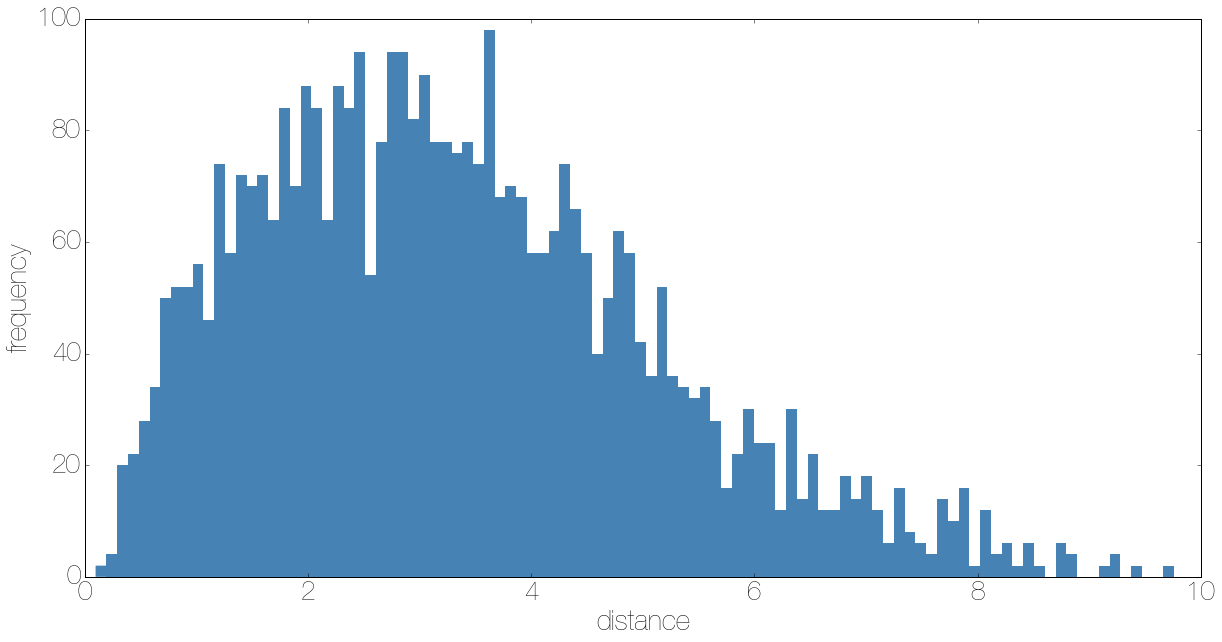

In [91]:
x1,y1=popCentres['WesternUrban']
x2,y2=popCentres['WesternRural']
distances=[]
for i in popCentres.keys():
    for j in popCentres.keys():
        if i!=j:
            x1,y1=popCentres[i]
            x2,y2=popCentres[j]
            distance=math.sqrt(math.pow(x1-x2,2)+math.pow(y1-y2,2))
            distances.append(distance)

print 'shortest distance: %.4f\nlargest distance: %.4f'%(min(distances),max(distances))
distances=sorted(distances)
## start figure
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

ax.hist(distances,bins=100,edgecolor='none',facecolor='steelblue')

ax.tick_params(labelsize=26)
ax.set_xlabel('distance',size=28)
ax.set_ylabel('frequency',size=28)
plt.show()

distribution of control point distances


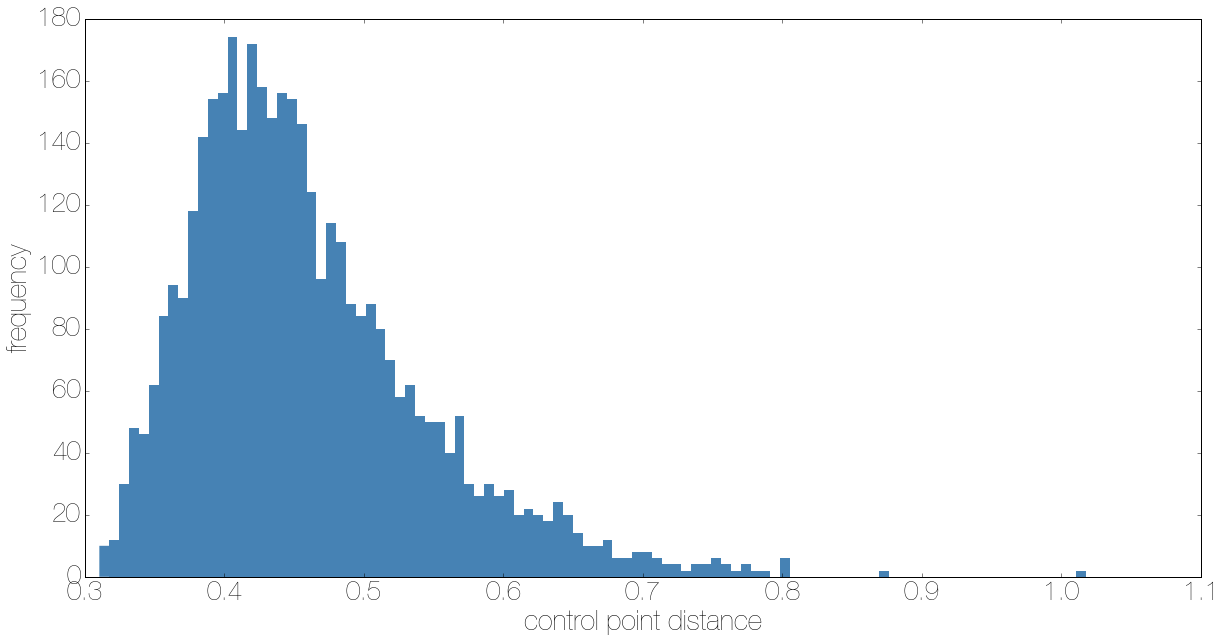

relationship between actual distance and control point distance


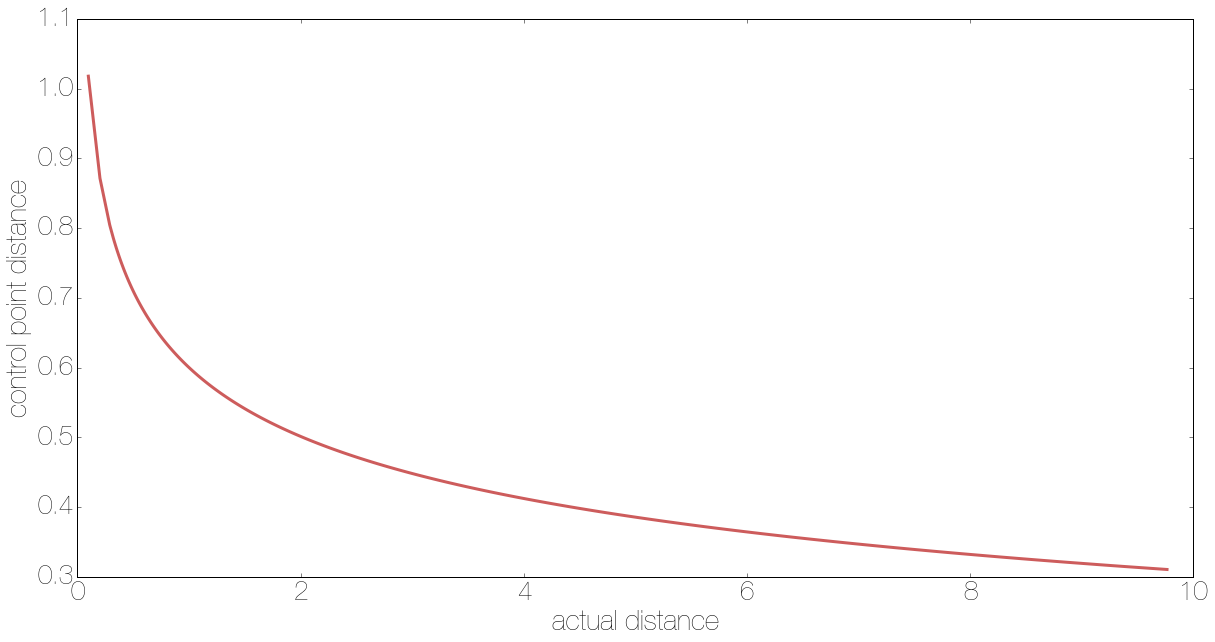

In [95]:

## start figure
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

ys=[-1+0.1+1/float(distance)**0.15+0.5 for distance in distances]

print 'distribution of control point distances'
ax.hist(ys,bins=100,edgecolor='none',facecolor='steelblue')
ax.set_xlabel('control point distance',size=28)
ax.set_ylabel('frequency',size=28)
ax.tick_params(labelsize=26)
plt.show()

print 'relationship between actual distance and control point distance'
## start figure
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

ax.plot(distances,ys,color='indianred',alpha=1,lw=3)
ax.set_xlabel('actual distance',size=28)
ax.set_ylabel('control point distance',size=28)
#ax.set_xlim(left=0.0)
#ax.set_ylim(bottom=0.0)
ax.tick_params(labelsize=26)
plt.show()